In [3]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("D:/Breast_Cancer_Detection/Infrared"))

['Test', 'Train', 'Validation']


In [4]:
print(os.listdir("D:/Breast_Cancer_Detection/Infrared/Train"))

['Healthy', 'Sick']


In [5]:
print(os.listdir("D:/Breast_Cancer_Detection/Infrared/Test"))

['Healthy', 'Sick']


In [6]:
print(os.listdir("D:/Breast_Cancer_Detection/Infrared/Validation"))

['Healthy', 'Sick']


In [7]:
TRAIN_DIR = "D:/Breast_Cancer_Detection/Infrared/Train/"
TEST_DIR = "D:/Breast_Cancer_Detection/Infrared/Test/"

Pre-Processing

In [8]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['Healthy']:
                label = 0
            elif nextdir in ['Sick']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [9]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [10]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['Healthy']:
                label = 0
            elif nextDir in ['Sick']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [11]:
X_train, y_train = get_data(TRAIN_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.31it/s]


In [12]:
X_test, y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.95it/s]


In [13]:
print(X_train.shape,'\n',X_test.shape)

(500, 150, 150, 3) 
 (200, 150, 150, 3)


In [14]:
print(y_train.shape,'\n',y_test.shape)

(500,) 
 (200,)


In [15]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [16]:
print(y_train.shape,'\n',y_test.shape)

(500, 2) 
 (200, 2)


In [17]:
Himages = os.listdir(TRAIN_DIR + "Healthy")
Simages = os.listdir(TRAIN_DIR + "Sick")

(Left) - Healthy Vs (Right) - Sick
-----------------------------------------------------------------------------------------------------------------------------------


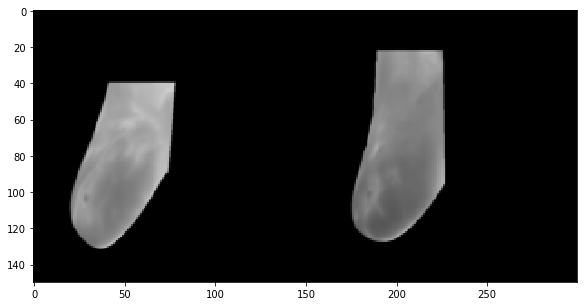

(Left) - Healthy Vs (Right) - Sick
-----------------------------------------------------------------------------------------------------------------------------------


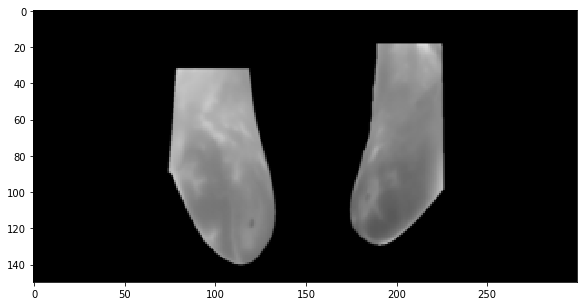

(Left) - Healthy Vs (Right) - Sick
-----------------------------------------------------------------------------------------------------------------------------------


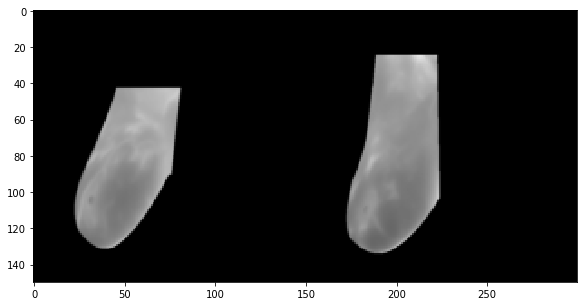

(Left) - Healthy Vs (Right) - Sick
-----------------------------------------------------------------------------------------------------------------------------------


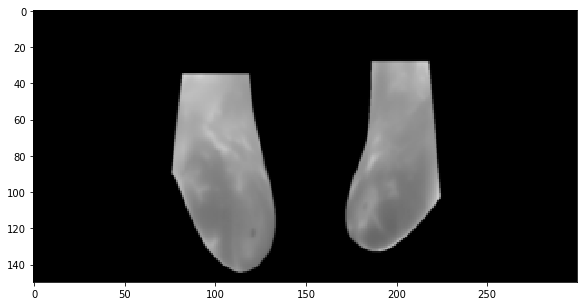

(Left) - Healthy Vs (Right) - Sick
-----------------------------------------------------------------------------------------------------------------------------------


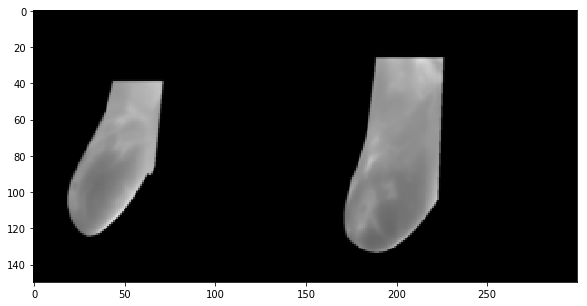

In [19]:
import matplotlib.pyplot as plt
def plotter(i):
    images1 = cv2.imread(TRAIN_DIR+"Sick/"+Simages[i])
    images1 = skimage.transform.resize(images1, (150, 150, 3) , mode = 'reflect')
    imageh1 = cv2.imread(TRAIN_DIR+"Healthy/"+Himages[i])
    imageh1 = skimage.transform.resize(imageh1, (150, 150, 3))
    pair = np.concatenate((imageh1, images1), axis=1)
    print("(Left) - Healthy Vs (Right) - Sick")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [20]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

c:\program files\python36\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [23]:
X_train=X_train.reshape(500,3,150,150)
X_test=X_test.reshape(200,3,150,150)

In [24]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

In [25]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [26]:
base_model.load_weights("D:/Downloads/inception_v3_weights.h5/inception_v3_weights.h5")

In [27]:
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 150, 150)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 74, 74)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 74, 74)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 256, 16, 16)  0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 16, 16)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 64, 16, 16)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 64, 16, 16)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 64, 16, 16)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 96, 16, 16)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 64, 16, 16)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 64, 16, 16)   0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, 128, 7, 7)    384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 128, 7, 7)    0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 7, 7)    0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 768, 7, 7)    0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 192, 7, 7)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 192, 7, 7)    576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 192, 7, 7)    576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 192, 7, 7)    576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 192, 7, 7)    576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 192, 7, 7)    0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, 192, 7, 7)    0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 768, 7, 7)    0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 192, 7, 7)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 192, 7, 7)    576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, 192, 7, 7)    576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 192, 7, 7)    0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 192, 7, 7)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 192, 7, 7)    258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 192, 7, 7)    576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, 384, 3, 3)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 192, 3, 3)    576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 320, 3, 3)    0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 768, 3, 3)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 768, 3, 3)    0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048, 3, 3)   0           mixed10[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           dropout_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
batch_norm

In [36]:
batch_size = 64
epochs = 10

In [37]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce] ,epochs=epochs)

Train on 500 samples, validate on 200 samples
Epoch 1/10
500/500 [==============================] - ETA: 7:17 - loss: 0.9805 - acc: 0.375 - ETA: 4:47 - loss: 0.7963 - acc: 0.546 - ETA: 3:50 - loss: 0.7119 - acc: 0.625 - ETA: 3:14 - loss: 0.5988 - acc: 0.687 - ETA: 2:48 - loss: 0.5947 - acc: 0.706 - ETA: 2:26 - loss: 0.5347 - acc: 0.744 - ETA: 2:07 - loss: 0.5145 - acc: 0.754 - ETA: 1:50 - loss: 0.5212 - acc: 0.757 - ETA: 1:34 - loss: 0.4953 - acc: 0.770 - ETA: 1:19 - loss: 0.4644 - acc: 0.790 - ETA: 1:04 - loss: 0.4592 - acc: 0.784 - ETA: 49s - loss: 0.4387 - acc: 0.794 - ETA: 35s - loss: 0.4227 - acc: 0.80 - ETA: 21s - loss: 0.3995 - acc: 0.81 - ETA: 8s - loss: 0.3812 - acc: 0.8187 - 247s 494ms/step - loss: 0.3747 - acc: 0.8220 - val_loss: 2.5772 - val_acc: 0.6150
Epoch 2/10
500/500 [==============================] - ETA: 2:54 - loss: 0.0668 - acc: 0.968 - ETA: 2:43 - loss: 0.1164 - acc: 0.953 - ETA: 2:33 - loss: 0.1184 - acc: 0.958 - ETA: 2:21 - loss: 0.1305 - acc: 0.953 - ETA: 2:08 

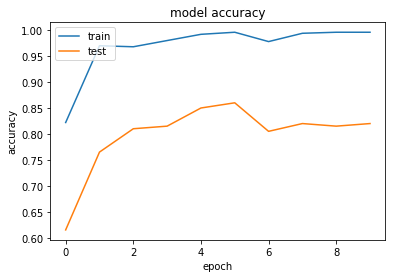

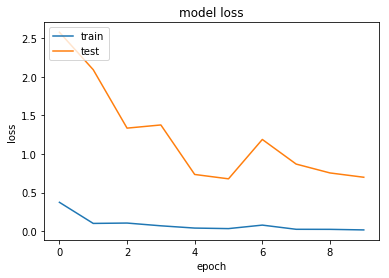

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

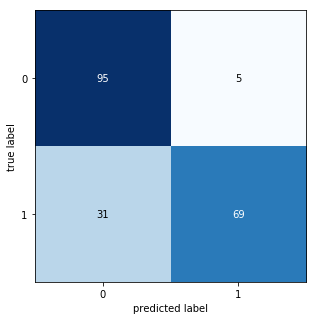

In [47]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()